In [145]:
#https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6
#https://github.com/waleedka/traffic-signs-tensorflow/blob/master/notebook1.ipynbhttps://github.com/waleedka/traffic-signs-tensorflow/blob/master/notebook1.ipynb
#https://towardsdatascience.com/recognizing-traffic-signs-with-over-98-accuracy-using-deep-learning-86737aedc2ab

#TODO: 
'''
- address potential issues of using different data types .ppm vs .png
'''

import os
import random
import skimage.data
import skimage.transform
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Allow image embeding in notebook
%matplotlib inline

def load_data(data_dir, ann_dir):
    labels = []
    images = []
    x1, x2, y1, y2 = 0, 0, 0, 0
    count = 0
    for fileName in os.listdir(ann_dir):
        if count == 500:
            break
        with open(os.path.join(ann_dir, fileName)) as f:
            if fileName.endswith(".txt"):
                for line in f:
                    lineList = f.readline()
                    if not lineList:
                        break
                    label,x1,y1,x2,y2,clean = lineList.split(',')
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    labels.append(label)
                    image = skimage.data.imread(os.path.join(data_dir,fileName[:-4]+".png"))
                    max_h, max_w = image.shape[0], image.shape[1]
                    image = skimage.util.crop(image,((y1, max_h - y2),(x1,max_w - x2),(0,0)), copy=False)
                    images.append(image)
                    count += 1
    return images, labels

ROOT_PATH = "BadNets/datasets/usts/"
train_data_dir = os.path.join(ROOT_PATH, "Images")
anno_dir = os.path.join(ROOT_PATH, "Annotations")
#test_data_dir = os.path.join(ROOT_PATH, "Images")

images, labels = load_data(train_data_dir, anno_dir)

In [146]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 3
Total Images: 500


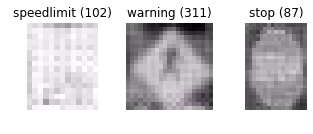

In [147]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("{0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

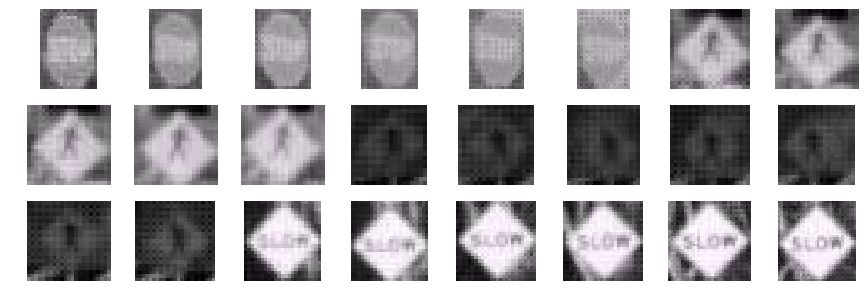

In [148]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 'stop')

In [149]:
#---------------------------------------------------------
# Handingly different size images

In [150]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (16, 13, 3), min: 151, max: 255
shape: (17, 14, 3), min: 165, max: 255
shape: (24, 17, 3), min: 44, max: 208
shape: (26, 17, 3), min: 67, max: 198
shape: (26, 18, 3), min: 60, max: 206


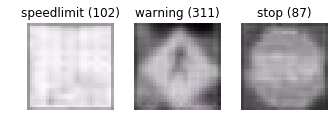

In [151]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]
display_images_and_labels(images32, labels)

In [99]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.11951593137254923, max: 0.9558823529411778
shape: (32, 32, 3), min: 0.06245404411764707, max: 0.9452359068627464
shape: (32, 32, 3), min: 0.6588235294117647, max: 0.9993451286764706
shape: (32, 32, 3), min: 0.611764705882353, max: 0.99854856004902
shape: (32, 32, 3), min: 0.20392156862745098, max: 0.9893918504901965


In [100]:
#--------------------------------------------------------------

In [101]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (500,) 
images:  (500, 32, 32, 3)


In [102]:
# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.contrib.layers.flatten(images_ph)

    # Fully connected layer. 
    # Generates logits of size [None, 62]
    logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))

    # Create training op.
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # And, finally, an initialization op to execute before training.
    init = tf.global_variables_initializer()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
images_flat:  Tensor("Flatten/flatten/Reshape:0", shape=(?, 3072), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


In [103]:
#-------------------------------------------------

In [114]:
# Create a session to run the graph we created.
session = tf.Session(graph=graph)

# First step is always to initialize all variables. 
# We don't care about the return value, though. It's None.
_ = session.run([init])

for i in range(201):
    _, loss_value = session.run([train, loss], 
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)

ValueError: invalid literal for int() with base 10: 'stop'

In [105]:
#-----------------------------------------------------------
# USING MODEL

['stop', 'warning', 'warning', 'stop', 'stop', 'warning', 'speedlimit', 'stop', 'warning', 'stop']
[ 2 10 10  2  9  9  2  2  9  2]


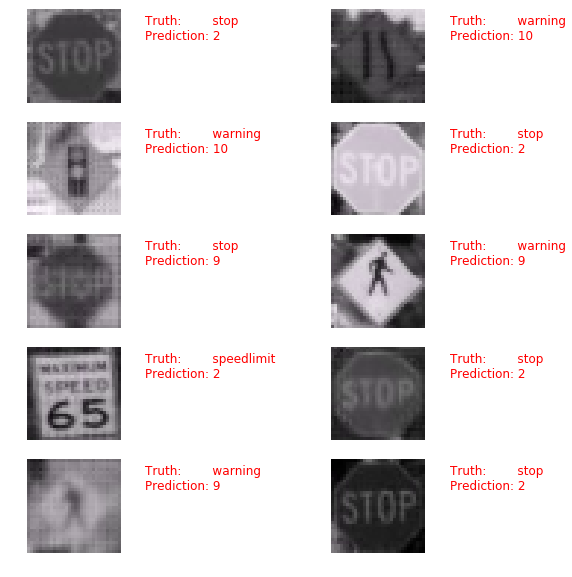

In [106]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

In [ ]:
#------------------------------------------------------ 
# EVALUATION

In [ ]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)

# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

In [ ]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

In [ ]:
# Close the session. This will destroy the trained model.
session.close()